In [ ]:
!nvidia-smi

Thu Mar 18 08:33:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |    864MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import backend as K 

warnings.filterwarnings("ignore")

# Reference

# https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/
# https://medium.datadriveninvestor.com/multivariate-time-series-using-rnn-with-keras-7f78f4488679

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
main_path = 'gdrive/My Drive/Colab Notebooks/DSAI_hw1'
print(os.listdir(main_path))

['本年度每日尖峰備轉容量率.csv', '台灣電力公司_過去電力供需資訊.csv']


***Normalization and Split Data into Train, Valid, Test set***

In [ ]:
n_past = 7
n_future = 7
n_features = 9

# Drop out the columns that we aren't looking for
df = pd.read_csv(os.path.join(main_path,'台灣電力公司_過去電力供需資訊.csv'))

df.drop(df.iloc[:, 7:-3], inplace = True, axis = 1)
df.drop(df.iloc[:, 0:1], inplace = True, axis = 1)
print(df.head(10))


# Train Valid Split
# 397 entries * 0.8 = 316
train_df = df[:317]
valid_df = df[317:]
# print(len(train_df))
# print(len(valid_df))

# Scaling
train = train_df
scalers = {}
for i in train_df.columns:
  scaler = MinMaxScaler(feature_range=(-1, 1))
  s = scaler.fit_transform(train[i].values.reshape(-1, 1))
  s = np.reshape(s, len(s))
  scalers['scaler_' + i] = scaler
  train[i] = s

valid = valid_df
for i in train_df.columns:
  scaler = scalers['scaler_'+i]
  s = scaler.transform(valid[i].values.reshape(-1,1))
  s = np.reshape(s, len(s))
  scalers['scaler_i'] = scaler
  valid[i] = s

# Convert Series to Samples

def split_dataset(dataset, n_past, n_future):
  X, Y = [], []
  for i in range(len(dataset)):
    if (i + n_past + n_future) > len(dataset):
      break
    x = dataset[i:i+n_past, :]
    y = dataset[i+n_past:i+n_past+n_future, :]
    X.append(x)
    Y.append(y)  
  return np.array(X), np.array(Y)


x_train, y_train = split_dataset(train.values, n_past, n_future)
print(x_train.shape)
print(y_train.shape)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

x_valid, y_valid = split_dataset(valid.values, n_past, n_future)
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

# print(x_train.shape)
# print(y_train.shape)
# print(x_valid.shape)
# print(y_valid.shape)

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
# #
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model.summary()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
model.compile(optimizer=Adam(), loss='mean_squared_error')
history = model.fit(x_train,y_train,epochs=50,validation_data=(x_valid,y_valid),batch_size=32,verbose=2,callbacks=[reduce_lr,callback])

   淨尖峰供電能力(MW)  尖峰負載(MW)  備轉容量(MW)  備轉容量率(%)  ...  民生用電(百萬度)  其他小水力  風力發電  太陽能發電
0        28125     25335      2790     11.01  ...    206.750   13.3  20.4    0.0
1        31303     28223      3080     10.91  ...    226.457   20.8   7.5    0.0
2        31676     28292      3384     11.96  ...    230.138   19.8  12.5    0.0
3        29219     25583      3636     14.21  ...    213.870   20.5  10.8    0.0
4        27456     24761      2695     10.88  ...    202.368   18.2   3.1    0.0
5        31653     28644      3009     10.51  ...    227.768   20.5   1.9    0.3
6        32248     29144      3104     10.65  ...    235.411   21.1   1.7    0.0
7        31779     28544      3235     11.33  ...    233.438   20.1  59.8    0.0
8        31861     28730      3131     10.90  ...    233.553   19.6  33.7    0.0
9        31774     28476      3298     11.58  ...    234.138    7.4  13.0   37.2

[10 rows x 9 columns]
(304, 7, 9)
(304, 7, 9)
Model: "model"
_______________________________________________

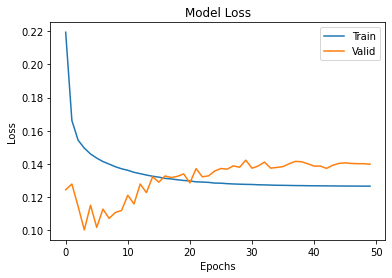

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
pred = model.predict(x_valid)

RangeIndex(start=0, stop=317, step=1)
RangeIndex(start=317, stop=397, step=1)
(67, 7, 9)


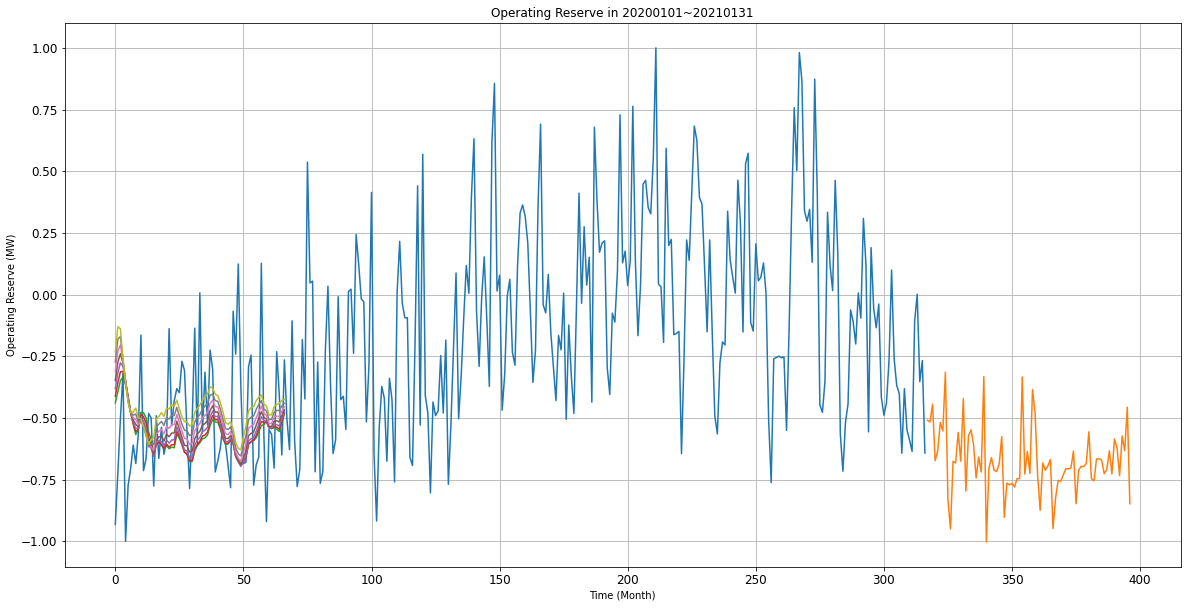

In [ ]:
# Plotting data
print(train.index)
print(valid.index)
print(pred.shape)
# cp = train.copy()
# print(cp.shape)
# cp[317:317+67,:] = pred[:,0,2]
train['備轉容量(MW)'].plot(figsize=(20, 10), fontsize=14)
valid['備轉容量(MW)'].plot(figsize=(20, 10), fontsize=14, title="Operating Reserve in 20200101~20210131")
plt.plot(pred[:,:,2])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Time (Month)')
plt.ylabel('Operating Reserve (MW)')
plt.grid(True)
plt.show()

In [ ]:
# Denormalize
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]    
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [ ]:
# for index,i in enumerate(train_df.columns):
#   print(i)
#   for j in range(1,6):    
#     rms=np.sqrt(np.mean((y_valid[:,j-1,index]-pred[:,-1,index])**2))
#     print(rms)    
#   print()
#   print()

In [ ]:
print('Pred shape:',pred.shape)
print('y_valid shape:',y_valid.shape)
print(pred[0,:,2])
print(y_valid[:7,:,2])
rmse = 0
for index in range(y_valid.shape[0]):
  rmse += np.sqrt(np.mean((pred[index,:,2]-y_valid[index,:,2])**2))
rmse /= y_valid.shape[0]
print(rmse)

Pred shape: (67, 7, 9)
y_valid shape: (67, 7, 9)
[3470.6924 3508.4292 3550.824  3597.2195 3647.2668 3700.47   3756.263 ]
[[3643. 2928. 2765. 3144. 3134. 3306. 3144.]
 [2928. 2765. 3144. 3134. 3306. 3144. 3495.]
 [2765. 3144. 3134. 3306. 3144. 3495. 2977.]
 [3144. 3134. 3306. 3144. 3495. 2977. 3287.]
 [3134. 3306. 3144. 3495. 2977. 3287. 3320.]
 [3306. 3144. 3495. 2977. 3287. 3320. 3237.]
 [3144. 3495. 2977. 3287. 3320. 3237. 3050.]]
288.21890855667243
